# Project 90 dataset

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import pystan as ps
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
import arviz as az
sns.set()

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData
from crawford_algorithm import simulating_rds_crawford, Crawford

In [2]:
rds_b = pickle.load(open('../models/prevalence_estimation/pickles/RDS_B_estimator.pkl', 'rb')) 
rds_model = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'rb'))

In [3]:
data_project90 = pd.read_csv('../data/Princeton_project_90/nodes.tsv', sep='\t')
edges_project90 = pd.read_csv('../data/Princeton_project_90/edges.tsv', sep='\t')

In [4]:
graph = nx.Graph()
for i, edge in edges_project90.iterrows():
    graph.add_node(edge['node1'], data=data_project90[data_project90.id == edge['node1']])
    graph.add_node(edge['node2'], data=data_project90[data_project90.id == edge['node2']])
    graph.add_edge(edge['node1'], edge['node2'])
components = list(nx.connected_components(graph))
G = graph.subgraph(components[0])

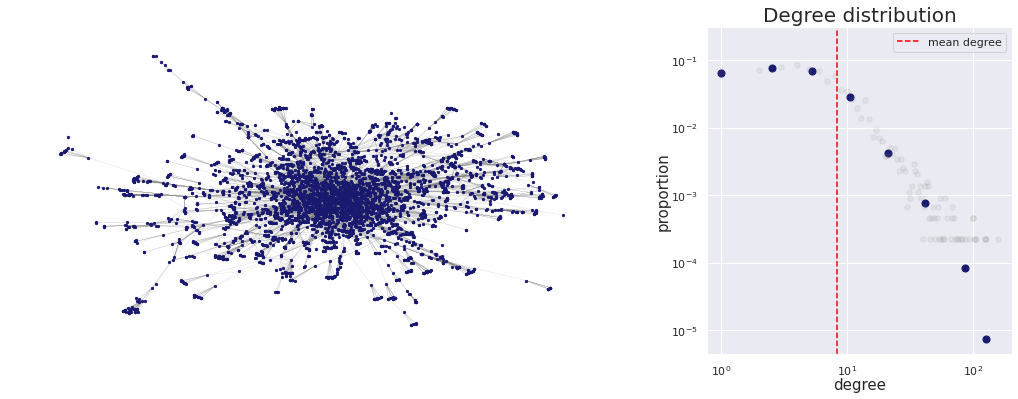

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios':(2,1)})

nx.draw(G, node_size=5, node_color='midnightblue', edge_color='grey', ax=ax[0], width=0.1)

degree_histogram = np.array(nx.degree_histogram(G))[1:]
degree_histogram = degree_histogram/degree_histogram.sum()

d_max = len(degree_histogram) - 1
n_max = int(np.log2(len(degree_histogram)))

# Log-binning
log_binning = np.zeros(n_max+1)
degree_histogram_log_binning = np.zeros(n_max+1)
for n in range(n_max+1): 
    bins = np.array([2**n + i for i in range(min(2**n, d_max - 2**n))])
    N_n = degree_histogram[bins].sum()
    degree_histogram_log_binning[n] = N_n/len(bins)
    log_binning[n] = (bins*degree_histogram[bins]).sum()/N_n
    
degrees = np.where(degree_histogram != 0)
        
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].axvline(np.array(G.degree)[:,1].mean(), linestyle='--', color='red', label='mean degree')

ax[1].scatter(log_binning, degree_histogram_log_binning, color = 'midnightblue', s = 50)
ax[1].scatter(degrees, degree_histogram[degrees], color = 'grey', alpha = 0.1, s = 30)
ax[1].set_title('Degree distribution', fontsize=20)
ax[1].set_xlabel('degree', labelpad = 0, fontsize=15)
ax[1].set_ylabel('proportion', labelpad = 0, fontsize=15)

ax[1].legend()

#plt.savefig('../images/graph_projet90_degree_distribution.pdf', bbox_inches='tight')
plt.show()

Deliting incomplete data and getting the larger component.

In [5]:
# removing 
df_project90 = data_project90.dropna()
graph        = graph.subgraph(df_project90.id)

# Getting the larger subgraph
components = list(nx.connected_components(graph))
subgraph   = graph.subgraph(components[0])
 
# Subgraph 
nodes = list(subgraph.nodes)
df    = df_project90[df_project90.id.isin(nodes)]

In [6]:
df.disabled.value_counts(dropna=False, normalize=True)

0.0    0.953053
1.0    0.046947
Name: disabled, dtype: float64

In [7]:
for i in range(1, 5):
    df.loc[:, 'race_{}'.format(i)] = 1 * (df['race'] == i)
    
spec    = 0.85
sens    = 0.9
p       = sens * df.disabled + (1 - df.disabled) * (1 - spec)
ro = np.random.RandomState(seed=738129)
df.loc[: ,'test'] = ro.binomial(n=1, p=p)
    
df = df.set_index('id').drop(columns=['race', 'disabled'])

/home/lucasmoschen/anaconda3/envs/tcc-emap/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [22]:
n_samples = 500
gen_graph = GenerateData()
rds_sample = gen_graph.RDS_generator(graph = subgraph, seed=2000, 
                                     n_seeds=10, sample_size = n_samples, 
                                     probs = [1/3,1/6,1/6,1/3], R=0)
rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
rds_data = df.loc[list(rds_sample.nodes)]

In [23]:
A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

In [24]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 0, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [25]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 459 ms, sys: 80.5 ms, total: 539 ms
Wall time: 57.6 s


In [27]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.077,0.082,0.000,0.235,0.001,0.001,3133.0,4300.0,1.00
sens,0.884,0.078,0.742,0.997,0.001,0.001,11261.0,4634.0,1.00
spec,0.835,0.041,0.764,0.913,0.001,0.001,1274.0,1518.0,1.00
effects[0],-0.182,0.759,-1.630,1.266,0.008,0.009,10230.0,5790.0,1.00
effects[1],-0.173,0.837,-1.790,1.369,0.008,0.010,11839.0,5425.0,1.00
effects[2],-0.055,0.909,-1.847,1.585,0.008,0.011,12324.0,6022.0,1.00
effects[3],-0.631,0.869,-2.240,1.050,0.008,0.008,10982.0,5556.0,1.00
effects[4],0.050,0.792,-1.451,1.548,0.008,0.009,9016.0,6103.0,1.00
effects[5],-0.114,0.904,-1.799,1.625,0.008,0.011,13671.0,5882.0,1.00
effects[6],0.127,0.894,-1.519,1.844,0.008,0.010,12556.0,6674.0,1.00


In [13]:
rds_crawford = simulating_rds_crawford(subgraph, n_samples=500, n_seeds=10, rate=1/5, probs=[1/3, 1/6, 1/6, 1/3], seed=421412)
rds_crawford['rds'].remove_nodes_from(list(nx.isolates(rds_crawford['rds'])))
rds_data = df.loc[list(rds_crawford['rds'].nodes)]

100%|██████████| 492/492 [00:00<00:00, 2058.24it/s]


In [14]:
A = nx.adjacency_matrix(rds_crawford['rds'].to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [15]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 470 ms, sys: 67.7 ms, total: 538 ms
Wall time: 1min


In [21]:
az.summary(fit_imperfect_rds, hdi_prob=.8)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.059,0.059,0.000,0.092,0.001,0.001,2972.0,4238.0,1.00
sens,0.888,0.074,0.823,0.984,0.001,0.000,9636.0,4561.0,1.00
spec,0.853,0.039,0.799,0.895,0.001,0.001,1997.0,1729.0,1.00
effects[0],-0.201,0.762,-1.154,0.738,0.008,0.009,9449.0,5798.0,1.00
effects[1],0.133,0.812,-0.893,1.099,0.009,0.010,8489.0,5396.0,1.00
effects[2],-0.392,0.858,-1.470,0.707,0.008,0.009,10396.0,6407.0,1.00
effects[3],-0.171,0.805,-1.154,0.884,0.008,0.009,10583.0,6126.0,1.00
effects[4],0.209,0.760,-0.611,1.237,0.008,0.009,9477.0,5001.0,1.00
effects[5],-0.097,0.960,-1.383,1.084,0.009,0.011,11396.0,5385.0,1.00
effects[6],0.072,0.820,-0.959,1.124,0.008,0.010,11535.0,5479.0,1.00


In [37]:
n_samples = 500
gen_graph = GenerateData()

seeds = []
while len(seeds) < 10:
    i = np.random.choice(subgraph.nodes)
    if (subgraph.nodes[i]['data'])['disabled'].iloc[0] == 1:
        seeds.append(i)
seeds = np.array(seeds)

rds_sample = gen_graph.RDS_generator(graph = subgraph, seed=2000, 
                                     n_seeds=10, sample_size = n_samples, 
                                     probs = [1/3,1/6,1/6,1/3], R=0, seeds=seeds)
rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
rds_data = df.loc[list(rds_sample.nodes)]

In [38]:
A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray() 
data = {
    "n_samples"    : rds_data.shape[0],
    "n_predictors" : rds_data.shape[1]-1,
    "Y"            : rds_data['test'],
    "X"            : rds_data.drop(columns='test').values,
    "adj_matrix"   : A, 
    "adj_pairs"    : int(A.sum()//2)
} 

data.update({    
    "Sigma"        : np.eye(15),
    "mu"           : np.zeros(15),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [41]:
%%time
fit_imperfect_rds = rds_model.sampling(data=data, warmup=2000, 
                                       iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho', 'omega'), 
                                       control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 8.47 s, sys: 176 ms, total: 8.64 s
Wall time: 1min 15s


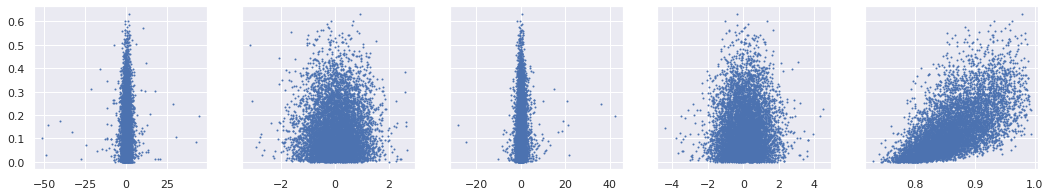

In [78]:
fig, ax = plt.subplots(1,5, figsize=(18,3), sharey=True)

prev_posterior = fit_imperfect_rds.extract()['prev']
omega_posterior = fit_imperfect_rds.extract()['omega']

s=1
ax[0].scatter(omega_posterior[:, 447], prev_posterior, s=s)
ax[1].scatter(omega_posterior[:, 41], prev_posterior, s=s)
ax[2].scatter(omega_posterior[:, 222], prev_posterior, s=s)
ax[3].scatter(omega_posterior[:, 282], prev_posterior, s=s)
#ax[4].scatter(omega_posterior[:, 478], prev_posterior, s=s)
ax[4].scatter(fit_imperfect_rds.extract()['spec'], prev_posterior, s=s)


In [74]:
[i for i,a in enumerate(dict(rds_sample.in_degree())) if dict(rds_sample.in_degree())[a] == 0]

[41, 57, 222, 282, 447]

In [72]:
rds_sample.nodes

{1: 1,
 3: 1,
 10: 1,
 12: 1,
 16: 1,
 17: 1,
 4113: 1,
 20: 1,
 21: 1,
 4117: 1,
 23: 1,
 24: 1,
 25: 1,
 4119: 1,
 4118: 1,
 2072: 1,
 29: 1,
 30: 1,
 2079: 1,
 39: 1,
 40: 1,
 4141: 1,
 4142: 1,
 4144: 1,
 4145: 1,
 50: 1,
 51: 1,
 4147: 1,
 4146: 1,
 4149: 1,
 55: 1,
 4148: 1,
 57: 1,
 59: 1,
 62: 1,
 64: 1,
 4160: 1,
 67: 1,
 68: 1,
 71: 1,
 75: 1,
 82: 0,
 91: 1,
 98: 1,
 100: 1,
 102: 1,
 103: 1,
 104: 1,
 2153: 1,
 2152: 1,
 2150: 1,
 108: 1,
 4198: 1,
 2158: 1,
 2159: 1,
 4210: 1,
 115: 1,
 2164: 0,
 119: 1,
 4215: 1,
 124: 1,
 129: 1,
 130: 1,
 132: 1,
 133: 1,
 134: 1,
 137: 1,
 138: 1,
 4234: 1,
 4235: 1,
 4236: 1,
 4233: 1,
 4237: 1,
 4238: 1,
 145: 1,
 140: 1,
 2187: 1,
 150: 1,
 151: 1,
 156: 1,
 161: 1,
 164: 1,
 4261: 1,
 4262: 1,
 4263: 1,
 166: 1,
 169: 1,
 171: 1,
 173: 1,
 2224: 1,
 181: 1,
 183: 1,
 2239: 1,
 2241: 1,
 2242: 1,
 196: 1,
 198: 1,
 200: 1,
 2255: 1,
 210: 1,
 214: 1,
 219: 1,
 220: 1,
 224: 1,
 2275: 1,
 230: 1,
 2279: 1,
 231: 1,
 2282: 1,
 2283: 1